In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib
import importance_sample_lib as imp_lib
import common_utils 

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=3, max_galaxies=3, num_bands=5, num_images=50, 
                        brightness = 5000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

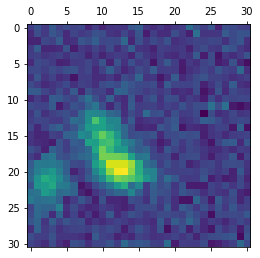

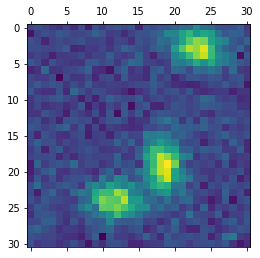

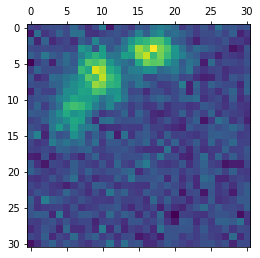

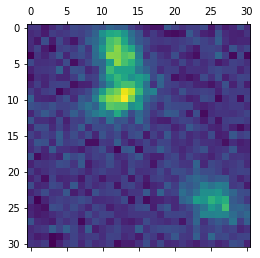

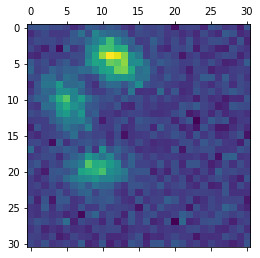

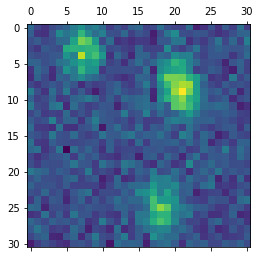

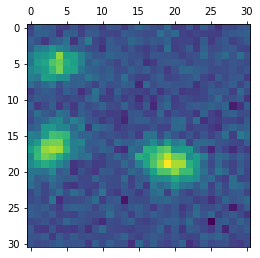

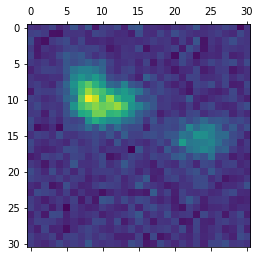

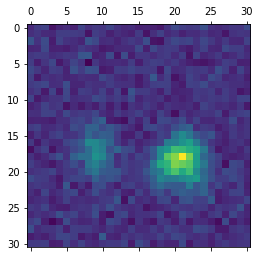

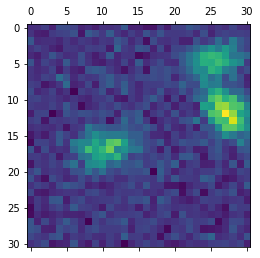

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
imp_weights = imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset=4, prob_off=0)

(array([352.,  40.,  23.,  10.,  16.,   8.,   9.,  10.,   9.,   7.,   5.,
          7.,   3.,   5.,   0.,   3.,   3.,   5.,   2.,   1.,   0.,   2.,
          2.,   5.,   0.,   0.,   0.,   0.,   0.,   3.]),
 array([0.        , 0.00068223, 0.00136447, 0.0020467 , 0.00272893,
        0.00341117, 0.0040934 , 0.00477564, 0.00545787, 0.0061401 ,
        0.00682234, 0.00750457, 0.0081868 , 0.00886904, 0.00955127,
        0.01023351, 0.01091574, 0.01159797, 0.01228021, 0.01296244,
        0.01364467, 0.01432691, 0.01500914, 0.01569138, 0.01637361,
        0.01705584, 0.01773808, 0.01842031, 0.01910254, 0.01978478,
        0.02046701]),
 <a list of 30 Patch objects>)

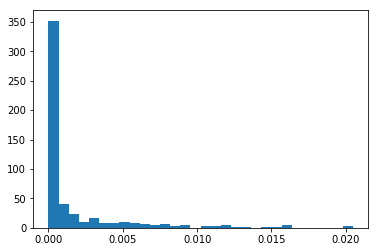

In [8]:
vec = imp_weights[2, :]
plt.hist(vec, bins = 30)

In [9]:
imp_weights

tensor(1.00000e-02 *
       [[ 0.0262,  0.0078,  0.0029,  ...,  0.0175,  0.0237,  0.0000],
        [ 0.0032,  0.0195,  0.0315,  ...,  0.0203,  0.0211,  0.0000],
        [ 0.0454,  0.1846,  0.2959,  ...,  0.0103,  0.0358,  0.0000],
        ...,
        [ 0.0300,  0.0994,  0.1672,  ...,  0.0139,  0.0115,  0.0000],
        [ 0.0019,  0.0251,  0.0146,  ...,  0.0180,  0.0160,  0.0000],
        [ 0.0396,  0.0280,  0.0021,  ...,  0.0251,  0.0366,  0.0000]])

In [10]:
torch.min(imp_weights)

tensor(0.)

# The VAE

In [11]:
one_galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [12]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

one_galaxy_vae.eval(); 

In [13]:
galaxy_vae = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=one_galaxy_vae)

In [14]:
pixel_probs = galaxy_vae.get_pixel_probs(images_batch1, backgrounds_batch1)

In [15]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [16]:
recon_mean, recon_var, is_on, kl_z = galaxy_vae.sample_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [17]:
map_pixel_loc

tensor([ 529,  529,  529,  529,  529,  529,  529,  529,  529,  529])

In [18]:
is_on

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

(array([529.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00080844, 0.05264371, 0.10447897, 0.15631424, 0.20814951,
        0.25998477, 0.31182004, 0.36365531, 0.41549057, 0.46732584,
        0.51916111]),
 <a list of 10 Patch objects>)

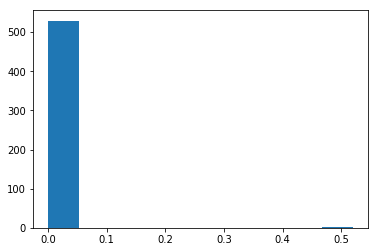

In [19]:
plt.hist(pixel_probs[0, :].detach())

In [20]:
recon_mean.sum()

tensor(0.)

In [21]:
recon_var.sum()

tensor(0.)

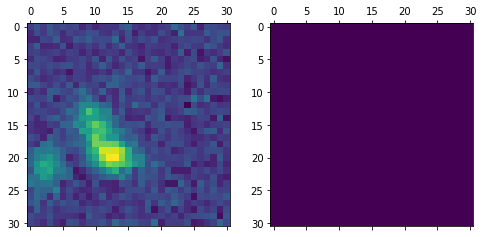

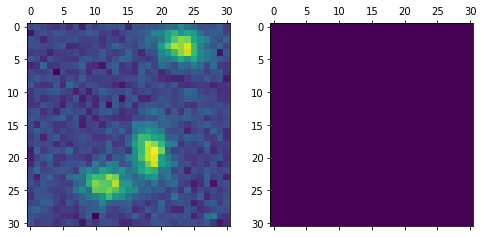

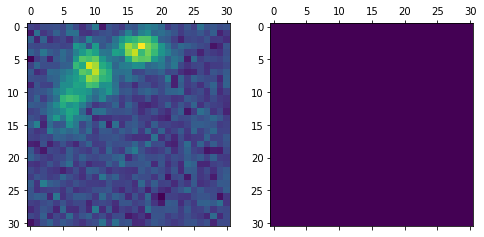

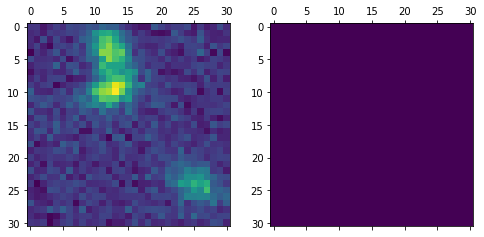

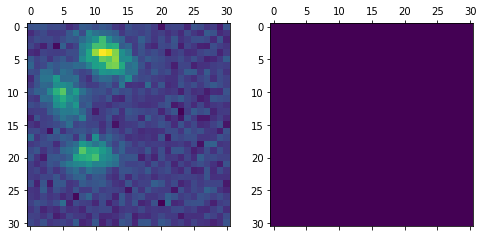

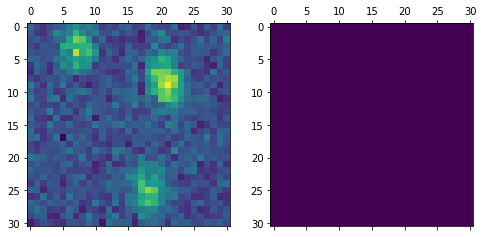

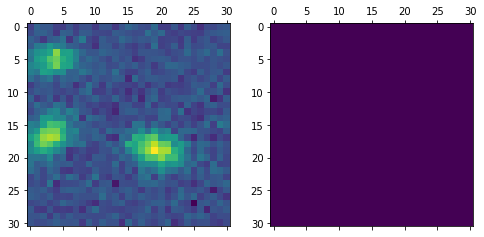

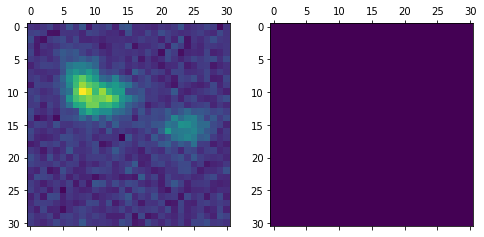

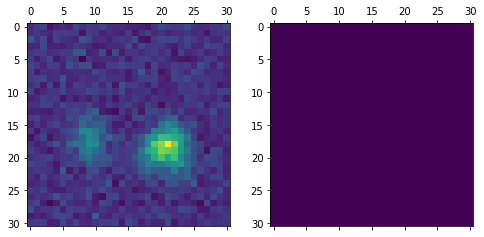

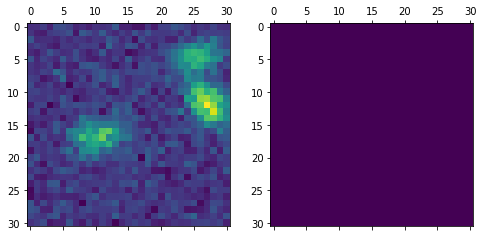

In [22]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


# Experimenting with new importance sampling functions

In [23]:
# function to normalize image
attn_offset = galaxy_vae.attn_offset
# normalized_image = imp_lib.crop_and_normalize_image(images_batch1, attn_offset)

In [24]:
# normalized_image.sum(dim = 1).sum(dim = 1) - 1

In [25]:
# append probability of being off
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1, attn_offset, prob_off)

In [26]:
np.max(np.abs(importance_weights.numpy().sum(1) - 1.0))

3.5762787e-07

In [27]:
print(np.abs(importance_weights.numpy().sum(1) - 1.0))

[1.1920929e-07 1.1920929e-07 2.9802322e-07 5.9604645e-08 2.3841858e-07
 2.3841858e-07 0.0000000e+00 2.3841858e-07 3.5762787e-07 0.0000000e+00]


In [28]:
assert np.max(np.abs(importance_weights[:, -1].numpy() - prob_off.numpy().squeeze())) < 1e-16
assert np.max(np.abs(importance_weights.numpy().sum(1) - 1.0)) < 1e-6

In [29]:
# visually check importance weights: 

In [30]:
prob_off = torch.zeros((images_batch1.shape[0], 1)) # pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset, prob_off)

In [31]:
which_n = 1
image_sampled = torch.zeros((side_len, side_len))
for i in range(10000): 
    z_sample = common_utils.sample_class_weights(importance_weights)
    pixel_2d = galaxy_vae.one_galaxy_vae.pixel_1d_to_2d(z_sample)
    image_sampled[pixel_2d[which_n, 0], pixel_2d[which_n, 1]] += 1

(array([390.,  48.,  30.,  23.,  12.,   9.,   8.,   4.,   1.,   5.]),
 array([0.        , 0.00190982, 0.00381964, 0.00572946, 0.00763928,
        0.00954909, 0.01145891, 0.01336873, 0.01527855, 0.01718837,
        0.01909819]),
 <a list of 10 Patch objects>)

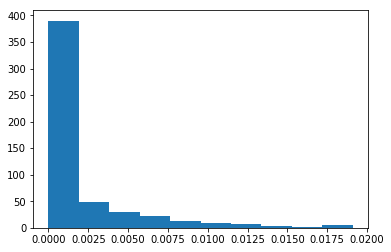

In [32]:
plt.hist(importance_weights[which_n, :])

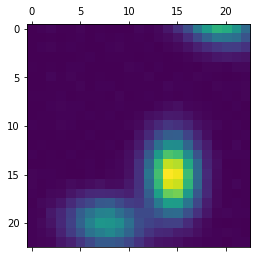

In [33]:
imp_weights_grid = importance_weights[:, 0:-1].view(images_batch1.shape[0], 23, 23)
plt.matshow(imp_weights_grid.detach()[which_n, :, :])

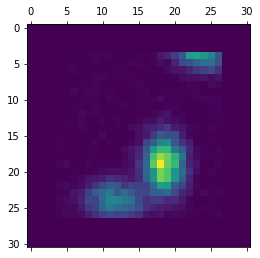

In [34]:
plt.matshow(image_sampled)

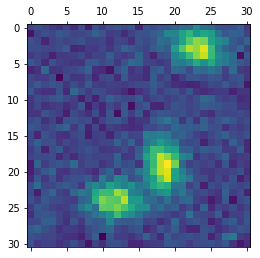

In [35]:
plt.matshow(images_batch1[which_n, 0, :, :])

In [36]:
# check optimizer goes through

In [37]:
optimizer = optim.Adam(galaxy_vae.parameters(), lr=0.01, weight_decay=1e-6)
optimizer.zero_grad()

In [38]:
pm_loss, neg_elbo, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

In [39]:
# check params
all_params = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params = torch.cat([params, all_params])

In [40]:
pm_loss

tensor(1.00000e+06 *
       2.7229)

In [41]:
pm_loss.backward()

In [42]:
optimizer.step()

In [43]:
_, neg_elbo2, _ = imp_lib.get_importance_sampled_galaxy_loss(galaxy_vae, images_batch1, backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True,
                                    max_detections = 2)

In [44]:
neg_elbo2

tensor(1.00000e+05 *
       3.0589)

In [45]:
# check params
all_params2 = torch.zeros(1)

for f in galaxy_vae.parameters():
    params = f.view(-1)
    all_params2 = torch.cat([params, all_params2])

In [46]:
torch.max(all_params2 - all_params)

tensor(1.00000e-02 *
       1.0000)

(array([752788.,  12497.,   5123.,   3557., 378048., 405864.,   3705.,
          5767.,  14706., 816466.]),
 array([-0.01000001, -0.008     , -0.006     , -0.004     , -0.002     ,
         0.        ,  0.002     ,  0.004     ,  0.006     ,  0.008     ,
         0.01000001]),
 <a list of 10 Patch objects>)

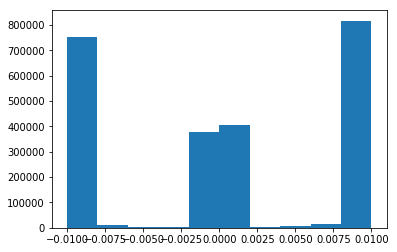

In [47]:
plt.hist((all_params2 - all_params).detach())

In [48]:
# Check train module

In [49]:
# train_module(vae, train_loader, test_loader, epochs,
#                         use_baseline = True,
#                         use_importance_sample = True,
#                         lr = 1e-4, weight_decay = 1e-6,
#                         save_every = 10,
#                         filename = './galaxy_vae_params',
#                         seed = 245345)

In [50]:
imp_lib.train_module(galaxy_vae, train_loader, test_loader, 
                        epochs = 12, save_every = 2, 
                        use_baseline = True, 
                        use_importance_sample = True, 
                        max_detections = 2, 
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

init batch loss: 325400 
  * init test loss: 335970
[1] loss: 301439  	[1.2 seconds]
[2] loss: 245024  	[1.2 seconds]
  * test loss: 233150
writing the network's parameters to ./test_epoch2.dat
[3] loss: 222655  	[1.2 seconds]
[4] loss: 198883  	[1.3 seconds]
  * test loss: 253758
writing the network's parameters to ./test_epoch4.dat
[5] loss: 261798  	[1.3 seconds]
[6] loss: 360406  	[1.3 seconds]
  * test loss: 402679
writing the network's parameters to ./test_epoch6.dat
[7] loss: 320958  	[1.1 seconds]
[8] loss: 318248  	[1.3 seconds]
  * test loss: 224026
writing the network's parameters to ./test_epoch8.dat
[9] loss: 277423  	[1.2 seconds]
[10] loss: 307762  	[1.3 seconds]
  * test loss: 248552
writing the network's parameters to ./test_epoch10.dat
[11] loss: 315060  	[1.3 seconds]


In [51]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [52]:
galaxy_vae_reload

OneGalaxyVAE(
  (attn_enc): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(10, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
      (8): Softmax()
    )
    (detect_none): Sequential(
      (0): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stri

In [53]:
np.load('./test_test_losses_array.npy')

array([335969.75, 233149.78, 253758.03, 402679.06, 224026.3 , 248551.66],
      dtype=float32)